In [1]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import platform
import psutil
import random
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm

from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Dataset loading

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="KQy5UhhJbKooQ1UHTO9R")
project = rf.workspace("brac-university-8frgk").project("license-plate-detection-lluwr")
version = project.version(1)
dataset = version.download("yolov8")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 35.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 92.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-sto


Extracting Dataset Version Zip to license-plate-detection-1 in yolov8:: 100%|██████████| 37284/37284 [00:05<00:00, 6477.71it/s] 


In [4]:
!cat /kaggle/working/license-plate-detection-1/data.yaml

names:
- '0'
- '1'
- '2'
- '3'
- '4'
- '5'
- '6'
- '7'
- '8'
- '9'
- ba
- ca
- chattogram
- da
- dhaka
- ga
- gha
- ha
- ja
- jashore
- ka
- kha
- khulna
- metro
- na
- ta
- va
nc: 27
roboflow:
  license: CC BY 4.0
  project: license-plate-detection-lluwr
  url: https://universe.roboflow.com/brac-university-8frgk/license-plate-detection-lluwr/dataset/1
  version: 1
  workspace: brac-university-8frgk
test: ../test/images
train: ../train/images
val: ../valid/images


### Training

In [11]:
model = YOLO('yolo11n.pt')  # 'n' = nano (fast), you can change to yolov8s.pt for better accuracy

results = model.train(
    data='/kaggle/working/license-plate-detection-1/data.yaml',
    epochs=20,          # medium dataset → more epochs
    imgsz=640,          # default image size
    batch=16,           # reduce to 8 if GPU memory is low
    lr0=0.0001,          # safer learning rate for fine-tuning
    pretrained=True   
)


Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/license-plate-detection-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=

train: Scanning /kaggle/working/license-plate-detection-1/train/labels.cache... 17322 images, 5413 backgrounds, 0 corrupt: 100%|██████████| 17322/17322 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 233.1±122.0 MB/s, size: 33.2 KB)


val: Scanning /kaggle/working/license-plate-detection-1/valid/labels.cache... 574 images, 131 backgrounds, 0 corrupt: 100%|██████████| 574/574 [00:00<?, ?it/s]


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000323, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train6
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.41G      1.217      3.053      1.422         43        640: 100%|██████████| 1083/1083 [04:04<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.67it/s]


                   all        574       2179      0.652      0.335      0.293      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.41G       0.98      1.639       1.23         30        640: 100%|██████████| 1083/1083 [03:55<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.00it/s]


                   all        574       2179      0.734      0.443      0.506      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.41G     0.9465      1.307       1.19         32        640: 100%|██████████| 1083/1083 [03:51<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.12it/s]


                   all        574       2179      0.855       0.48      0.586       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.41G      0.914      1.124      1.165         54        640: 100%|██████████| 1083/1083 [03:51<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.11it/s]


                   all        574       2179      0.757      0.539      0.608      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.41G      0.888      1.004      1.144         57        640: 100%|██████████| 1083/1083 [03:51<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.20it/s]


                   all        574       2179      0.775      0.569      0.639      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.41G     0.8683     0.9303      1.131         50        640: 100%|██████████| 1083/1083 [03:51<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.10it/s]


                   all        574       2179       0.86      0.554       0.65      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.41G     0.8492     0.8758      1.119         77        640: 100%|██████████| 1083/1083 [03:53<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.11it/s]


                   all        574       2179      0.849      0.571      0.673      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.41G       0.84     0.8421      1.112         58        640: 100%|██████████| 1083/1083 [03:53<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.21it/s]


                   all        574       2179      0.854      0.576      0.669      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.41G     0.8224     0.7978      1.102         42        640: 100%|██████████| 1083/1083 [03:51<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.16it/s]


                   all        574       2179      0.831      0.614       0.73       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.41G     0.8199     0.7739      1.099         26        640: 100%|██████████| 1083/1083 [03:52<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.92it/s]


                   all        574       2179      0.839       0.62      0.728      0.576
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.41G     0.8433     0.6238      1.128         44        640: 100%|██████████| 1083/1083 [03:50<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.21it/s]


                   all        574       2179      0.809      0.673      0.726      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.41G     0.8291      0.583      1.121         15        640: 100%|██████████| 1083/1083 [03:49<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.11it/s]


                   all        574       2179      0.813      0.671       0.74      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.41G     0.8095     0.5531      1.106         21        640: 100%|██████████| 1083/1083 [03:50<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.27it/s]

                   all        574       2179      0.846      0.661      0.775      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.41G     0.7979       0.53      1.101         22        640: 100%|██████████| 1083/1083 [03:49<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.10it/s]


                   all        574       2179      0.825      0.679      0.743       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.41G     0.7863     0.5109      1.092         17        640: 100%|██████████| 1083/1083 [03:49<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.28it/s]

                   all        574       2179      0.805      0.735      0.748      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.41G     0.7686     0.4851      1.082         28        640: 100%|██████████| 1083/1083 [03:48<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.26it/s]


                   all        574       2179      0.745      0.763      0.771      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.41G     0.7579     0.4745      1.077         37        640: 100%|██████████| 1083/1083 [03:48<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.26it/s]

                   all        574       2179      0.825      0.725      0.768      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.41G     0.7446     0.4573       1.07         15        640: 100%|██████████| 1083/1083 [03:49<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.70it/s]


                   all        574       2179      0.824      0.718      0.766      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.41G     0.7297     0.4445      1.062         27        640: 100%|██████████| 1083/1083 [03:48<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.49it/s]

                   all        574       2179       0.81      0.731      0.781      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.41G     0.7182     0.4287      1.052         17        640: 100%|██████████| 1083/1083 [03:48<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.38it/s]

                   all        574       2179       0.81      0.726      0.773      0.613



20 epochs completed in 1.305 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 5.5MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,587,417 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.09it/s]
invalid value encountered in less
invalid value encountered in less


                   all        574       2179      0.848      0.661      0.775      0.622
                     0        249        297       0.94      0.963      0.972      0.738
                     1        177        246      0.919      0.972      0.988       0.75
                     2        110        125      0.908      0.952      0.971      0.755
                     3        114        141      0.971      0.945      0.984      0.776
                     4        114        131      0.947      0.953      0.975      0.752
                     5        110        144      0.933      0.993      0.994      0.808
                     6         92        101       0.91      0.921       0.97      0.779
                     7         85         88      0.952      0.909      0.967      0.757
                     8         96        109      0.962      0.934      0.985      0.765
                     9         99        109      0.913      0.899      0.958      0.729
                    b

In [13]:

results_df = pd.read_csv('/kaggle/working/runs/detect/train6/results.csv')
results_df.head()


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,247.842,1.21713,3.05307,1.42223,0.65188,0.33529,0.29336,0.22072,0.99456,1.38710,1.17954,0.000108,0.000108,0.000108
1,2,487.016,0.98003,1.63859,1.23038,0.73384,0.44346,0.50601,0.38531,0.92079,1.00549,1.04013,0.000205,0.000205,0.000205
2,3,722.112,0.94651,1.30731,1.19031,0.85466,0.48011,0.58597,0.44001,0.94672,0.88443,1.02845,0.000291,0.000291,0.000291
3,4,956.729,0.91403,1.12434,1.16530,0.75671,0.53897,0.60774,0.46768,0.90307,0.79126,0.97754,0.000275,0.000275,0.000275
4,5,1191.710,0.88803,1.00366,1.14407,0.77519,0.56913,0.63897,0.49092,0.88027,0.70897,0.96844,0.000259,0.000259,0.000259


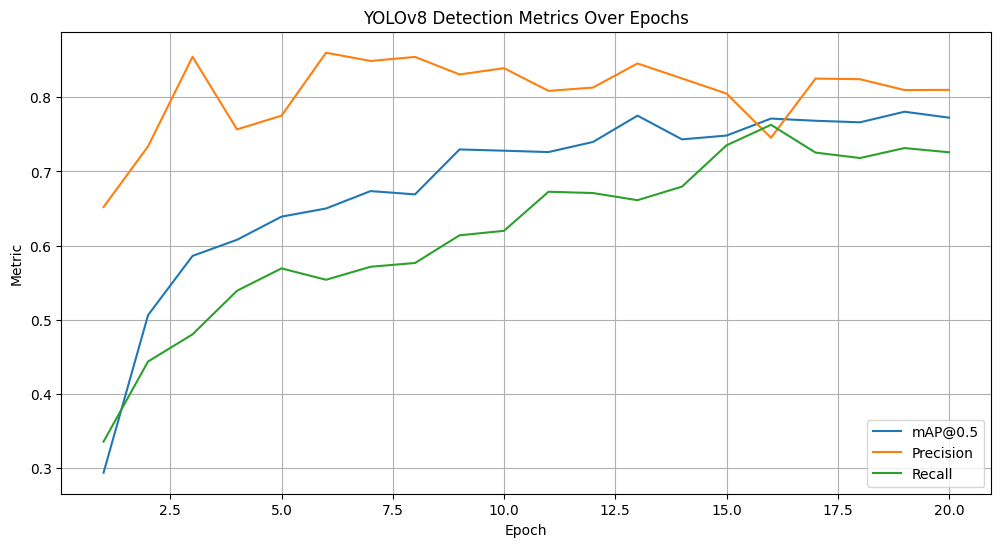

In [14]:
# ploting key matrix 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(results_df['epoch'], results_df['metrics/precision(B)'], label='Precision')
plt.plot(results_df['epoch'], results_df['metrics/recall(B)'], label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('YOLOv8 Detection Metrics Over Epochs')
plt.legend()
plt.grid()
plt.show()


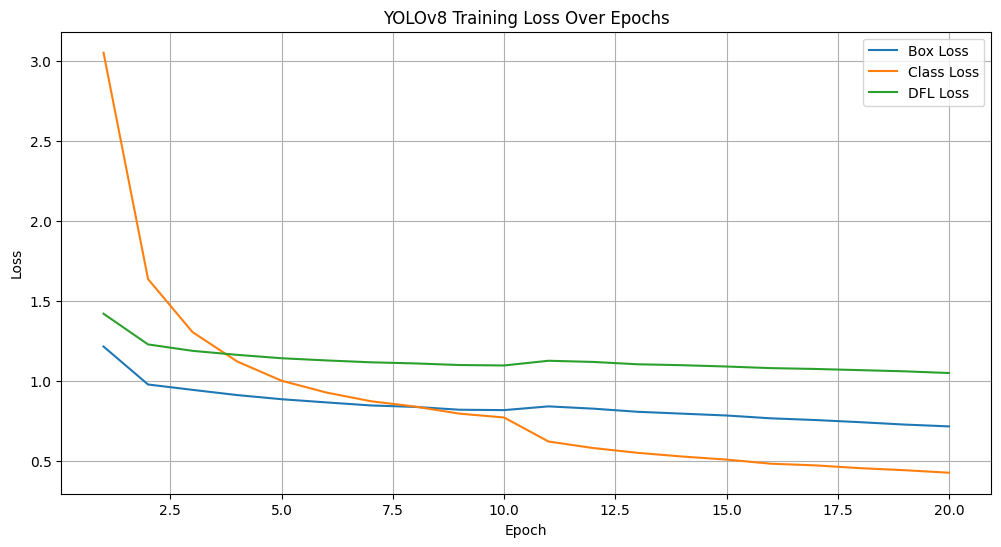

In [15]:
# training loss
plt.figure(figsize=(12, 6))
plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Box Loss')
plt.plot(results_df['epoch'], results_df['train/cls_loss'], label='Class Loss')
plt.plot(results_df['epoch'], results_df['train/dfl_loss'], label='DFL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('YOLOv8 Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


### Testing


image 1/4 /kaggle/input/yolo11-test/bus.png: 544x640 1 0, 11.3ms
image 2/4 /kaggle/input/yolo11-test/images.jpeg: 512x640 1 0, 8.7ms
image 3/4 /kaggle/input/yolo11-test/motocycle.jpg: 416x640 2 0s, 8.4ms
image 4/4 /kaggle/input/yolo11-test/original.jpg: 384x640 1 0, 9.0ms
Speed: 2.0ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict3


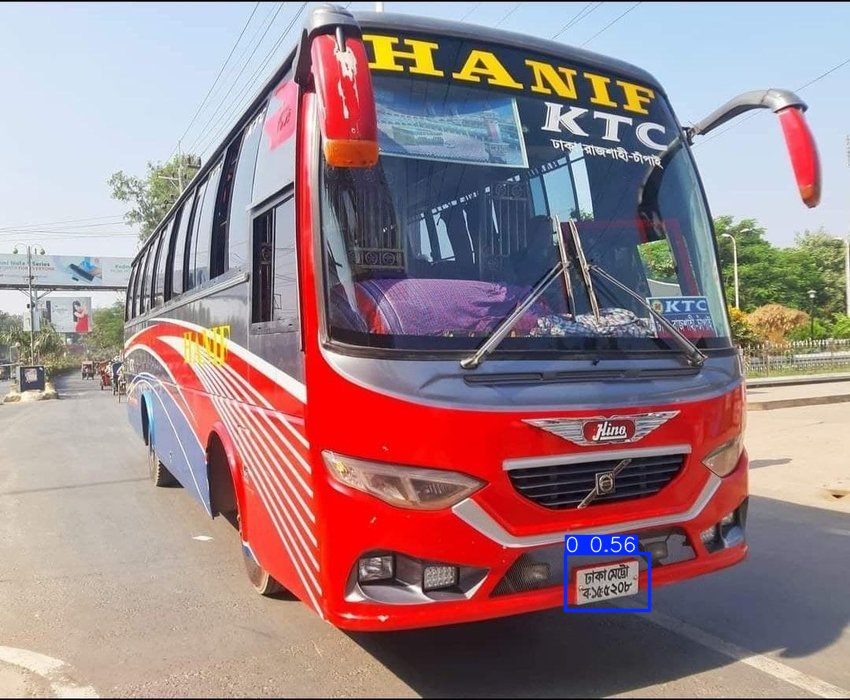

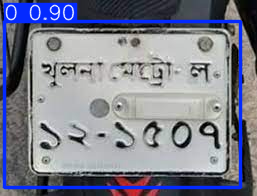

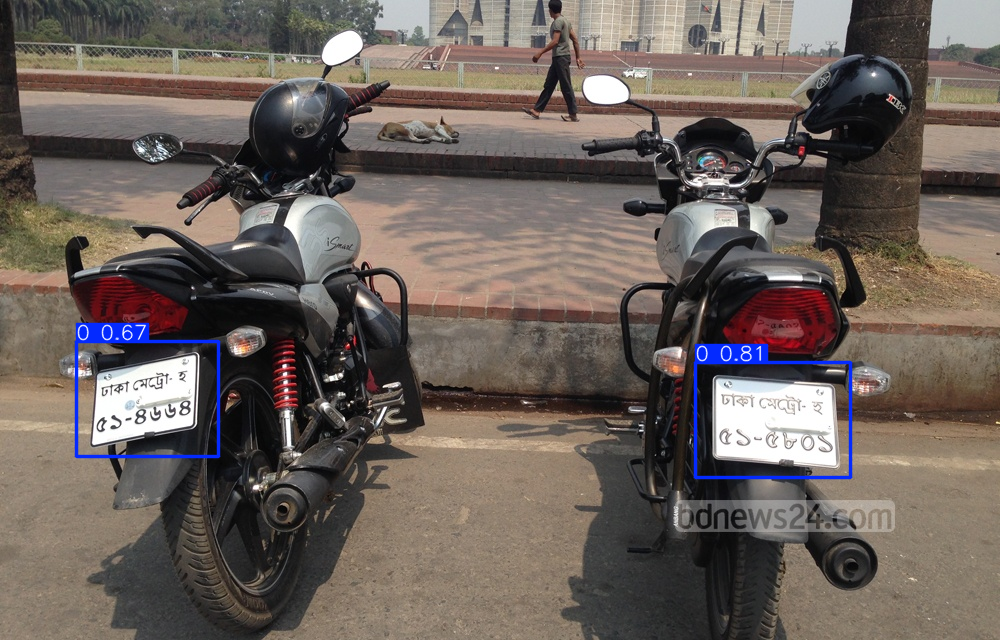

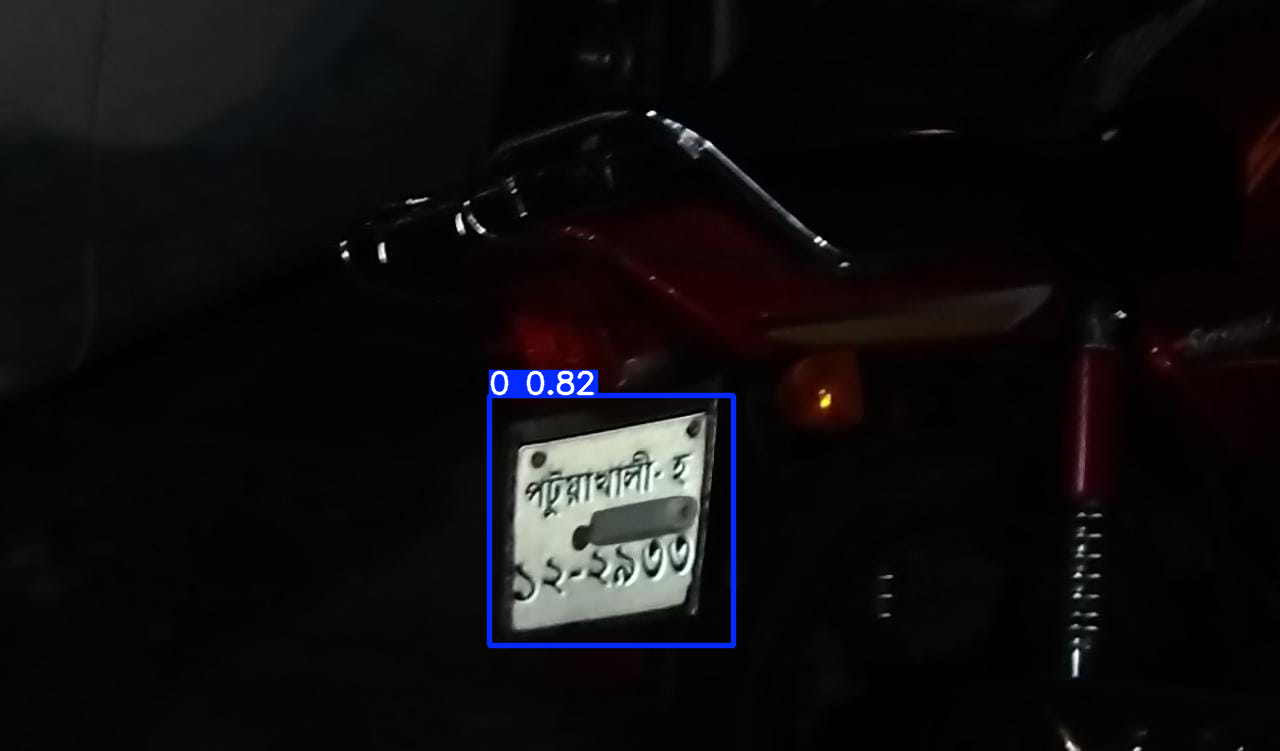

In [18]:
# Load trained model
model = YOLO("runs/detect/train6/weights/best.pt")

results = model.predict(
    source="/kaggle/input/yolo11-test",  # can be image, folder, video, or webcam (0)
    conf=0.25,
    save=True
)

# Show result
for i in results:
    i.show()
